In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 73.5MB/s]
100%|██████████| 21/21 [01:14<00:00,  3.54s/it]


Epoch [1/15], Loss: 20.0264, Accuracy: 53.33%


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Epoch [2/15], Loss: 13.9486, Accuracy: 60.61%


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Epoch [3/15], Loss: 12.4637, Accuracy: 68.48%


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Epoch [4/15], Loss: 11.5280, Accuracy: 67.88%


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Epoch [5/15], Loss: 7.6848, Accuracy: 83.03%


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Epoch [6/15], Loss: 3.5317, Accuracy: 92.73%


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Epoch [7/15], Loss: 1.4874, Accuracy: 98.18%


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Epoch [8/15], Loss: 1.0690, Accuracy: 98.18%


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Epoch [9/15], Loss: 0.0805, Accuracy: 100.00%


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Epoch [10/15], Loss: 1.0515, Accuracy: 97.58%


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Epoch [11/15], Loss: 0.5116, Accuracy: 98.18%


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Epoch [12/15], Loss: 1.1034, Accuracy: 98.18%


100%|██████████| 21/21 [00:18<00:00,  1.14it/s]


Epoch [13/15], Loss: 1.0257, Accuracy: 98.79%


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Epoch [14/15], Loss: 0.2772, Accuracy: 99.39%


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Epoch [15/15], Loss: 1.2617, Accuracy: 97.58%
Model saved as 'cnn_vit_classifier.pth'
mAP score (AP for class 'waste_absent'): 0.9608
mAP score (AP for class 'waste_present'): 0.9775


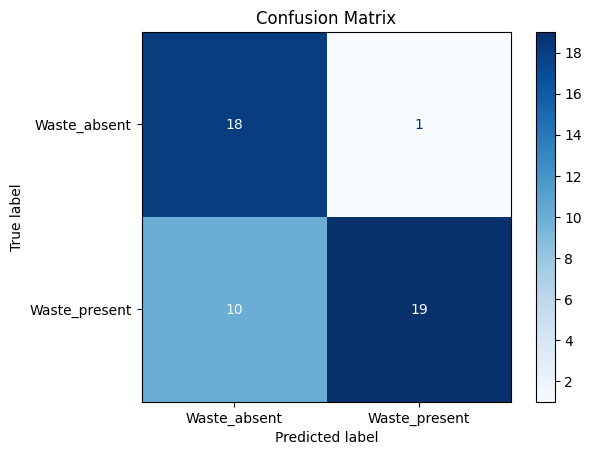

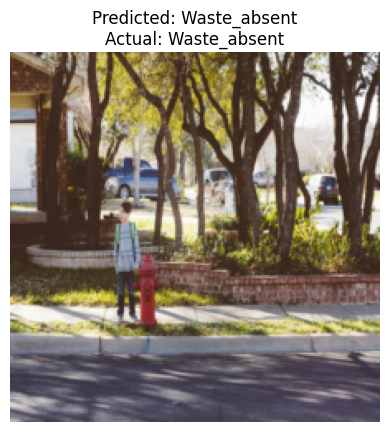

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Hybrid CNN + ViT Model ---
class CNNViT(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNViT, self).__init__()
        # CNN backbone
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Flatten CNN output
        self.flatten = nn.Flatten()
        self.linear_proj = nn.Linear(128 * 56 * 56, 768)  # ViT base input dim

        # Vision Transformer
        self.vit = models.vit_b_16(pretrained=True)
        self.vit.heads = nn.Linear(768, num_classes)

    def forward(self, x):
        x = self.cnn(x)                          # (B, 128, 56, 56)
        x = self.flatten(x)                      # (B, 128*56*56)
        x = self.linear_proj(x)                  # (B, 768)
        x = x.unsqueeze(1)                       # (B, 1, 768) like a patch
        x = self.vit.encoder(x)                  # ViT encoder output
        x = x.mean(dim=1)                        # Aggregate features
        x = self.vit.heads(x)                    # Classify
        return x

# --- Transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# --- Dataset ---
dataset = datasets.ImageFolder(root="/content/drive/MyDrive/review two data", transform=transform)
class_names = dataset.classes  # ['waste_absent', 'waste_present']

# --- Split ---
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

# --- Model, Loss, Optimizer ---
model = CNNViT(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 15

# --- Training Loop ---
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Save model
torch.save(model.state_dict(), "cnn_vit_classifier.pth")
print("Model saved as 'cnn_vit_classifier.pth'")

# --- Evaluation (mAP, Confusion Matrix) ---
model.eval()
all_labels, all_probs, all_preds = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

ap_0 = average_precision_score(all_labels == 0, all_probs[:, 0])
ap_1 = average_precision_score(all_labels == 1, all_probs[:, 1])

print(f"mAP score (AP for class 'waste_absent'): {ap_0:.4f}")
print(f"mAP score (AP for class 'waste_present'): {ap_1:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# --- Sample Prediction Visualization ---
index = random.randint(0, len(test_set) - 1)
sample_image, sample_label = test_set[index]
image_tensor = sample_image.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(image_tensor)
    _, pred_class = torch.max(output, 1)

img_np = sample_image.permute(1, 2, 0).cpu().numpy()
plt.imshow(img_np)
plt.title(f"Predicted: {class_names[pred_class.item()]}\nActual: {class_names[sample_label]}")
plt.axis("off")
plt.show()


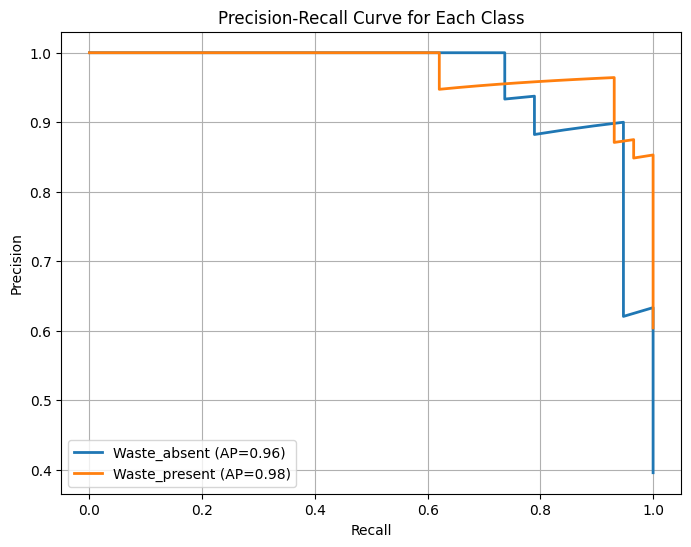

In [3]:
from sklearn.metrics import precision_recall_curve, auc

plt.figure(figsize=(8, 6))

for i, class_name in enumerate(class_names):
    binary_labels = (all_labels == i).astype(int)
    precision, recall, _ = precision_recall_curve(binary_labels, all_probs[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f"{class_name} (AP={pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.grid(True)
plt.show()


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Epoch [1/15] Train Loss: 0.0554 | Train Acc: 97.58% | Val Loss: 0.2144 | Val Acc: 86.96%


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Epoch [2/15] Train Loss: 0.0037 | Train Acc: 100.00% | Val Loss: 0.2604 | Val Acc: 91.30%


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Epoch [3/15] Train Loss: 0.0006 | Train Acc: 100.00% | Val Loss: 0.3218 | Val Acc: 91.30%


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Epoch [4/15] Train Loss: 0.0004 | Train Acc: 100.00% | Val Loss: 0.3283 | Val Acc: 91.30%


100%|██████████| 21/21 [00:20<00:00,  1.03it/s]


Epoch [5/15] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.3351 | Val Acc: 91.30%


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Epoch [6/15] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.3389 | Val Acc: 91.30%


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Epoch [7/15] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.3451 | Val Acc: 91.30%


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Epoch [8/15] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.3508 | Val Acc: 91.30%


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Epoch [9/15] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.3557 | Val Acc: 91.30%


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Epoch [10/15] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.3595 | Val Acc: 91.30%


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Epoch [11/15] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.3655 | Val Acc: 91.30%


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Epoch [12/15] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.3703 | Val Acc: 91.30%


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Epoch [13/15] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.3762 | Val Acc: 91.30%


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Epoch [14/15] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.3807 | Val Acc: 91.30%


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Epoch [15/15] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.3841 | Val Acc: 91.30%


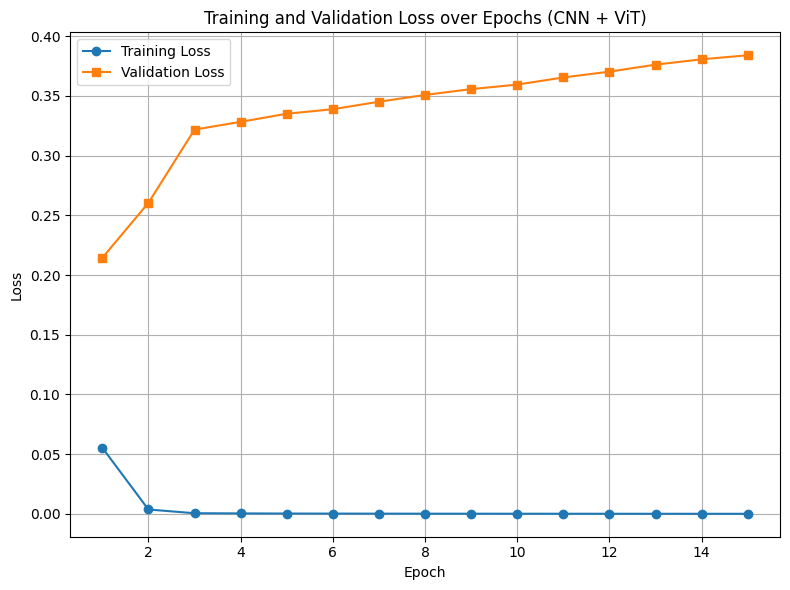

In [4]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

# --- Plot Training vs. Validation Loss ---
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs (CNN + ViT)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
